In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from pathlib import Path
from cycler import cycler
from scipy.signal import medfilt
from scipy.optimize import curve_fit
%matplotlib inline

Load data:

In [2]:
filename_list=glob('./data/*.txt')

In [3]:
data={}
for file in filename_list:
    test_name=file[7:-4]
    data_tmp=np.loadtxt(file, skiprows=1)
    data[test_name]=data_tmp[:,:]

In [4]:
def calc_work_hard_correct(values,n):
    m= int(n/10)
    eng_strain=values[:,0]/100
    eng_stress=values[:,1]
    stress=(eng_stress*(1 + eng_strain))
    elastic_strain=stress/63e3
    eng_strain=eng_strain-elastic_strain
    strain=(np.log(1+eng_strain))[::n]
    stress=(eng_stress*(1 + eng_strain))[::n]
    work_hard=(np.gradient(stress,n)/np.gradient(strain,n))
    #work_hard=np.convolve(work_hard, np.ones((m,))/m, mode='same')
    return strain, stress, work_hard

## Fitting

In [5]:
def get_bounds(values, n):
    fit_pars={}
    strain,stress,work_hard=calc_work_hard_correct(values, n)
    s_wh_dist= np.sqrt((work_hard-stress)**2)
    yield_pos = np.where(strain<=0.002)[0][-1]
    neck_pos = np.where(s_wh_dist==np.min(s_wh_dist))[0][-1]
    strain_bounds = (strain[yield_pos], strain[neck_pos])
    stress_bounds = (stress[yield_pos], stress[neck_pos])
    work_hard_bounds = (work_hard[yield_pos], work_hard[neck_pos])
    
    return strain_bounds, stress_bounds, work_hard_bounds

In [6]:
def trim_stress_strain(strain, stress, work_hard, strain_bounds):
    yield_pos = np.where(strain==strain_bounds[0])[0][-1]
    neck_pos =  np.where(strain==strain_bounds[1])[0][-1]
    stress_trim= stress[yield_pos:neck_pos]
    strain_trim= strain[yield_pos:neck_pos]
    work_hard_trim = work_hard[yield_pos:neck_pos]
    return strain_trim, stress_trim, work_hard_trim

In [7]:
def hardening(strain, omega_1, sigma_1, omega_2, sigma_2):
    tau = omega_1*np.exp(-omega_1/sigma_1*strain) + omega_2*np.exp(-omega_2/sigma_2*strain)
    return tau

In [92]:
def fit_hardening(data, n=60):
    fit_results={}
    for test, values in sorted(data.items()):
        print('Doing test {}'.format(test))
        fit_params={}
        strain_bounds, stress_bounds, work_hard_bounds = get_bounds(values , n)
        strain_filt, stress_filt, work_hard_filt = calc_work_hard_correct(values, int(n/10))
        strain_trim, stress_trim, work_hard_trim = trim_stress_strain(strain_filt,
                                                                      stress_filt, 
                                                                      work_hard_filt, 
                                                                      strain_bounds)
        test_omega_1= work_hard_bounds[0]
        test_omega_2= work_hard_bounds[1]
        test_sigma_1= np.float(np.diff(stress_bounds))
        test_sigma_2= np.float(np.diff(stress_bounds)/10)
    
        pars, covar = curve_fit(hardening,strain_trim, work_hard_trim,
                                p0=[test_omega_1, test_sigma_1, test_omega_2, test_sigma_2])
        fit_params={'Omega_1': pars[0],
                    'Sigma_1': pars[1],
                    'Omega_2': pars[2],
                    'Sigma_2': pars[3],
                    'Covariance' : covar}
        fit_results[test] = fit_params
    
    return fit_results
        

In [93]:
samp_step=60

In [94]:
strain, stress, work_hard = calc_work_hard_correct(data['PA_20%_0h RA140'], n=samp_step)

In [95]:
fits=fit_hardening(data, n=samp_step)

Doing test PA_20%_0h RA140
Doing test PA_20%_4h RA140
Doing test PA_72%_0hRA
Doing test PA_72%_4hRA140
Doing test ST_20%_0h RA140
Doing test ST_20%_4h RA140
Doing test ST_72%_0hRA
Doing test ST_72%_4hRA140
Doing test T6_6


In [96]:
fit_df=pd.DataFrame.from_dict(fits)

In [101]:
np.sqrt(np.diag(fit_df['PA_20%_0h RA140']['Covariance']))

array([7.82398469e+04, 1.78628553e+01, 1.89591202e+03, 2.47335442e+00])

In [14]:
def check_fit(data,fits,test, n= 60):
    values=data[test]
    params=fits[test]
    strain_filt, stress_filt, work_hard_filt = calc_work_hard_correct(values, int(n/10))
    test_strain=np.linspace(0, strain_filt[-1], 100)
    tau_test=hardening(test_strain, params['Omega_1'], 
                                    params['Sigma_1'], 
                                    params['Omega_2'], 
                                    params['Sigma_2']) 
    plt.plot(test_strain, tau_test)
    plt.plot(strain_filt[10:], work_hard_filt[10:])
    plt.ylim([0,8000])

In [15]:
def check_fit_all(data,fits, n= 60):
    fig, axes = plt.subplots(3,3,figsize=(12,6),sharex ='all',sharey='all')
    for ax,(test,values) in zip(axes.ravel(),sorted(data.items())):
        params=fits[test]
        strain_filt, stress_filt, work_hard_filt = calc_work_hard_correct(values, int(n/10))
        test_strain=np.linspace(0, strain_filt[-1], 100)
        tau_test=hardening(test_strain, params['Omega_1'], 
                                        params['Sigma_1'], 
                                        params['Omega_2'], 
                                        params['Sigma_2']) 
        ax.set_title(test)
        ax.plot(strain_filt[5:], work_hard_filt[5:],'o',alpha = 0.2)
        ax.plot(test_strain, tau_test,lw=2)
        ax.set_ylim([0,4000])
    axes[1,0].set_ylabel('Work hardening rate (MPa)')
    axes[2,1].set_xlabel('Strain')
    return fig

In [82]:
def uniform_elongation(data,fits, n= 60):
    uniform_elongation={}
    fig, axes = plt.subplots(3,3,figsize=(12,6),sharex ='all',sharey='all')
    for ax,(test,values) in zip(axes.ravel(),sorted(data.items())):
        params=fits[test]
        strain_filt, stress_filt, work_hard_filt = calc_work_hard_correct(values, int(n/10))
        test_strain=np.linspace(0, strain_filt[-1], np.shape(stress_filt)[0])
        tau_test=hardening(strain_filt, params['Omega_1'], 
                                        params['Sigma_1'], 
                                        params['Omega_2'], 
                                        params['Sigma_2']) 
        
        square_diff=np.sqrt((stress_filt-tau_test)**2)
        strain_neck = strain_filt[np.where(square_diff==np.min(square_diff))[0]]
        stress_neck = stress_filt[np.where(square_diff==np.min(square_diff))[0]]
        strain_fail = strain_filt[-1]
        ax.set_title(test)
        ax.plot(strain_filt[5:], work_hard_filt[5:],'o',alpha = 0.2)
        ax.plot(strain_filt[5:], stress_filt[5:],'+')
        ax.plot(strain_neck, stress_neck,'ro')
        ax.plot(strain_filt, tau_test,lw=2)
        ax.set_ylim([0,1000])
        uniform_elongation[test]=np.array([strain_neck, strain_fail], dtype='float')
        
    axes[1,0].set_ylabel('Work hardening rate (MPa)')
    axes[2,1].set_xlabel('Strain')
    return fig,uniform_elongation 

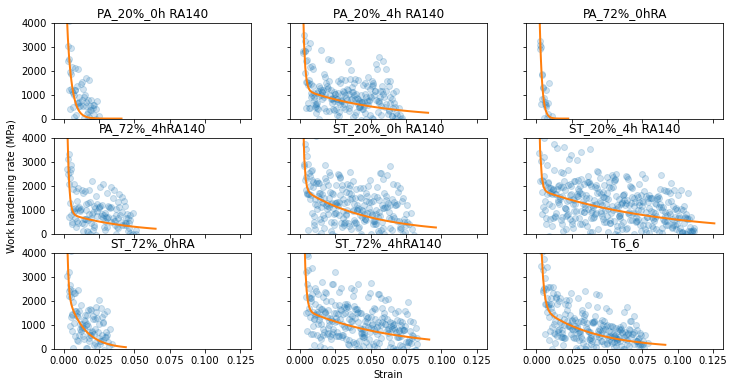

In [68]:
figure = check_fit_all(data,fits,n=samp_step)

In [69]:
figure.savefig('hardening_fit_comparison.png', dpi = 150)

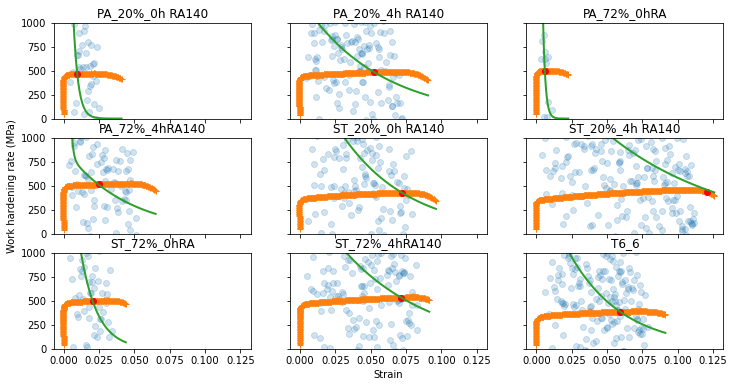

In [83]:
figure_ue, ue = uniform_elongation(data,fits,n=samp_step)

In [84]:
ue_df=pd.DataFrame.from_dict(ue)

In [85]:
ue

{'PA_20%_0h RA140': array([0.00936637, 0.0408336 ]),
 'PA_20%_4h RA140': array([0.05239066, 0.09054682]),
 'PA_72%_0hRA': array([0.00602631, 0.02248974]),
 'PA_72%_4hRA140': array([0.02458899, 0.06494471]),
 'ST_20%_0h RA140': array([0.07200991, 0.09607097]),
 'ST_20%_4h RA140': array([0.12086176, 0.12588353]),
 'ST_72%_0hRA': array([0.02044752, 0.04388929]),
 'ST_72%_4hRA140': array([0.07152633, 0.09134015]),
 'T6_6': array([0.05944225, 0.09119756])}

<AxesSubplot:>

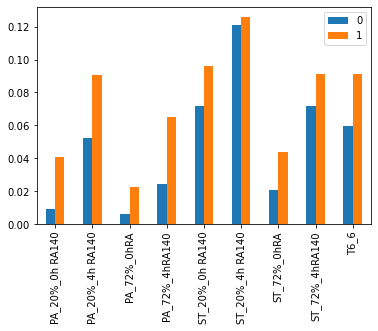

In [89]:
ue_df.transpose().plot(kind='bar',legend=['Uniform elongation','Elongation to failure'])

<AxesSubplot:>

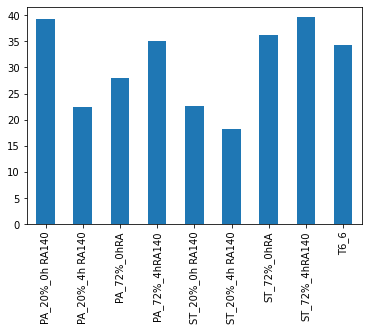

In [90]:
fit_df.transpose()['Sigma_1'].plot(kind='bar')

In [19]:
data.keys()

dict_keys(['ST_72%_4hRA140', 'T6_6', 'PA_72%_4hRA140', 'PA_20%_0h RA140', 'PA_72%_0hRA', 'ST_72%_0hRA', 'ST_20%_4h RA140', 'ST_20%_0h RA140', 'PA_20%_4h RA140'])

In [21]:
values = data['ST_72%_4hRA140']
n=60
strain_filt, stress_filt, work_hard_filt = calc_work_hard_correct(values, int(n/10))

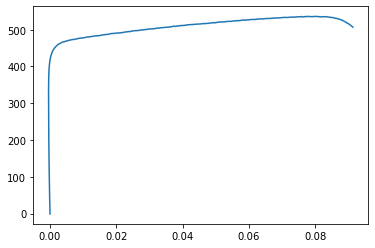

In [22]:
plt.plot(strain_filt,stress_filt)